In [1]:
%load_ext autoreload
%autoreload 2

['V1', 'V2', 'V6', 'V3', 'V4', 'V5', 'Y', 'V7', 'V8', 'V9']
True
/knowledge
addtemporal


forbiddirect

requiredirect
[V1 --- V3, V6 --- V7, V6 --- Y, Y --- V7, Y --- V9, V2 --- V5, V6 --- V9, V3 --- V5, V7 --- V9]
nodes = ['V1', 'V2', 'V6', 'V3', 'V4', 'V5', 'Y', 'V7', 'V8', 'V9']
di_edges = [('V2', 'V4'), ('V2', 'V8'), ('V3', 'V4'), ('V5', 'V4'), ('Y', 'V8')]
bi_edges = []


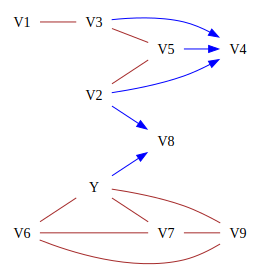

In [2]:
from discovery import run_pc, draw, run_fci
from fix import fix_DAG, fix_ADMG

nodes, edges = run_pc("data/temp.csv")#, knowledge="knowledge.txt")
# nodes, edges = run_fci(".csv")
# nodes, edges = run_pc("big_noise_binary.csv")


# node, edges = fix_ADMG(nodes, edges)

print("nodes =", nodes)
print("di_edges =", [(x[0], x[2]) for x in edges if x[1] == "-->"])
print("bi_edges =", [(x[0], x[2]) for x in edges if x[1] == "<->"])


# print("edges =", [(x[0], x[2]) for x in edges])


draw(nodes, edges)



In [231]:
from causal import CausalDAG, augmented_ipw, compute_confidence_intervals

import pandas as pd

df = pd.read_csv('binary_small_noise.csv')

nodes = ['V8', 'V2', 'V4', 'Y', 'V6', 'V3', 'V5', 'V7', 'V9', 'V1']
edges = [#('Y', 'V5'),
    ('V2', 'V8'), ('V2', 'V4'), ('Y', 'V8'), ('V4', 'Y'), ('V2', 'V3'), ('V3', 'Y'), ('V2', 'V5'), ('V3', 'V5'), ('Y', 'V7'), ('V8', 'V9'), ('V7', 'V9'), ('V6', 'Y'), ('V1', 'V3'), ('V1', 'Y'), ('V3', 'V4')]


#TODO mess with graph

dag = CausalDAG(nodes, edges)

treatment_nodes = ['V8', 'V2', 'V4', 'V6', 'V3', 'V5', 'V7', 'V9', 'V1']
# treatment_nodes = ['V9']

for i in treatment_nodes:
    
    out = dag.find_minimal_optimal_backdoor(i, "Y")
    if out is None:
        print(i, "Y", "[No Causal Relationship]")
        continue
    treatment, outcome, adj_set = out
    print(treatment, outcome, adj_set)
    print(dag.valid_backdoor_set(treatment, outcome, adj_set))
    
    print(augmented_ipw(df, treatment, outcome, adj_set), compute_confidence_intervals(df, (treatment, outcome, adj_set), augmented_ipw))

    


# print(squash_paths(dag.find_causal_paths("V9", "Y")))
dag.draw()

Y V8 ['V2']
True
0.236 (0.199, 0.277)
V2 Y []
True
0.104 (0.044, 0.173)
V4 Y ['V3', 'V1']
True
0.014 (-0.091, 0.111)
V6 Y []
True


KeyboardInterrupt: 

0.501
0.488
0.492
Treatment: V1 Outcome Y
Backdoor: []
0.048 (-0.008, 0.102)
Treatment: V2 Outcome Y
Backdoor: []
0.01 (-0.053, 0.072)
Treatment: V3 Outcome Y
IV: V1
0.168 (-0.036, 0.354)
Treatment: V4 Outcome Y
Backdoor: ['V2']
0.064 (-0.009, 0.11)
V5 Y [No Causal Relationship]
Treatment: V6 Outcome Y
Frontdoor: V7
0.302 (0.247, 0.36)
Treatment: V7 Outcome Y
Backdoor: ['V6']
0.585 (0.535, 0.636)
Treatment: Y Outcome V8
Backdoor: ['V2']
0.191 (0.133, 0.246)


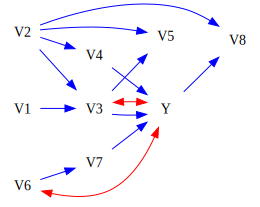

In [260]:
from causal import CausalADMG
from causal import iv_adjustment, frontdoor_ipw
import numpy as np

nodes = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'Y', 'V7', 'V8']
di_edges = [('V1', 'V3'), ('V2', 'V3'), ('V2', 'V4'), ('V2', 'V5'), ('V3', 'Y'), ('V6', 'V7'), ('V7', 'Y'), ('V3', 'V5'), ('V4', 'Y'), ('V2', 'V8'), ('Y', 'V8')]
bi_edges = [('V3', 'Y'), ('V6', 'Y')]
df = pd.read_csv('mixed_standard_binary.csv')

G = CausalADMG(nodes, di_edges, bi_edges)
print(np.mean(df["V6"]))
print(np.mean(df["V7"]))
print(np.mean(df["Y"]))


treatment_nodes = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8']
# treatment_nodes = ['V6']

for i in treatment_nodes:
    
    out = G.find_minimal_adjustment_set(i, "Y")
    if out is None:
        print(i, "Y", "[No Causal Relationship]")
        continue
    treatment, outcome, adj_set = out
    
    print("Treatment:", treatment, "Outcome", outcome)
    
    valid_backdoor = G.valid_backdoor_set(treatment, outcome, adj_set)
    
    if valid_backdoor:
        print("Backdoor:", adj_set)
        print(augmented_ipw(df, treatment, outcome, adj_set), compute_confidence_intervals(df, (treatment, outcome, adj_set), augmented_ipw))
        
    else:
        
        front_out = G.find_mediator(treatment, outcome)
        if front_out is not None:
            mediator, adj_set = front_out
            print("Frontdoor:", mediator)
            print(frontdoor_ipw(df, treatment, outcome, mediator, adj_set), compute_confidence_intervals(df, (treatment, outcome, mediator, adj_set), frontdoor_ipw))
            
        else:
            iv_out = G.find_instrument(treatment, outcome)
            if iv_out is not None:
                instrument, adj_set = iv_out
                print("IV:", instrument)
                print(iv_adjustment(df, treatment, outcome, instrument, adj_set), compute_confidence_intervals(df, (treatment, outcome, instrument, adj_set), iv_adjustment))
                
            else:
                print("Cannot Compute Causal Effect")
        
            
    
    
    # print(augmented_ipw(df, treatment, outcome, adj_set), compute_confidence_intervals(df, treatment, outcome, adj_set, augmented_ipw))

    
G.draw()


In [72]:
from learning import prepare_data
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

feats, Xtrain, Ytrain, Xtest, Ytest = prepare_data("standard_binary.csv", 800, "Y", offset=False)
# clf = tree.DecisionTreeClassifier(max_depth=None)
# clf = GradientBoostingClassifier(n_estimators=100)
# clf = BaggingClassifier(tree.DecisionTreeClassifier(max_depth=None), n_estimators=100)
clf = RandomForestClassifier(n_estimators=100)

clf.fit(Xtrain, Ytrain.flatten())

# tree.plot_tree(clf)
count = 0
predictions = clf.predict(Xtest)
ground = Ytest.flatten()

assert len(predictions) == len(ground)
for i in range(len(predictions)):
    if predictions[i] == ground[i]:
        count += 1


#         count += 1
print(count / len(predictions))

0.735
